In [11]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import leafmap
import json
from ipyleaflet import GeoJSON

In [2]:
road_segments = gpd.read_file('airview_dublincity_roaddata_shp')
road_segments.head()

,road_id,osm_id,osm_code,osm_fclass,osm_name,osm_ref,osm_oneway,osm_maxspe,osm_layer,osm_bridge,...,COpoints,COdrives,CO_mgm3,O3points,O3drives,O3_ugm3,PM25points,PM25drives,PM25_ugm3,geometry
0,3633278,497788125,5141,service,NaN,NaN,B,30,0,false,...,0,NaN,NaN,0,NaN,NaN,2,1.0,3.030,"LINESTRING (-6.15647 53.39440, -6.15665 53.39408)"
1,3639035,500417276,5141,service,NaN,NaN,B,0,0,false,...,0,NaN,NaN,0,NaN,NaN,1,1.0,5.042,"LINESTRING (-6.32663 53.34215, -6.32662 53.342..."
2,2099409,236680313,5141,service,NaN,NaN,B,0,0,false,...,0,NaN,NaN,0,NaN,NaN,1,1.0,32.500,"LINESTRING (-6.18915 53.37956, -6.18953 53.37994)"
3,3636088,498987932,5141,service,NaN,NaN,B,0,0,false,...,0,NaN,NaN,0,NaN,NaN,1,1.0,6.882,"LINESTRING (-6.27962 53.32629, -6.27965 53.326..."
4,3962473,684445633,5141,service,NaN,NaN,B,0,0,false,...,0,NaN,NaN,1,1.0,54.447,1,1.0,7.111,"LINESTRING (-6.26444 53.31320, -6.26444 53.313..."


In [3]:
null_rows = road_segments[road_segments['PM25_ugm3'].isnull()]
# null_rows
road_segments = road_segments.dropna(subset="PM25_ugm3")
road_segments['PM25_ugm3'].isnull().sum()

0

<Axes: >

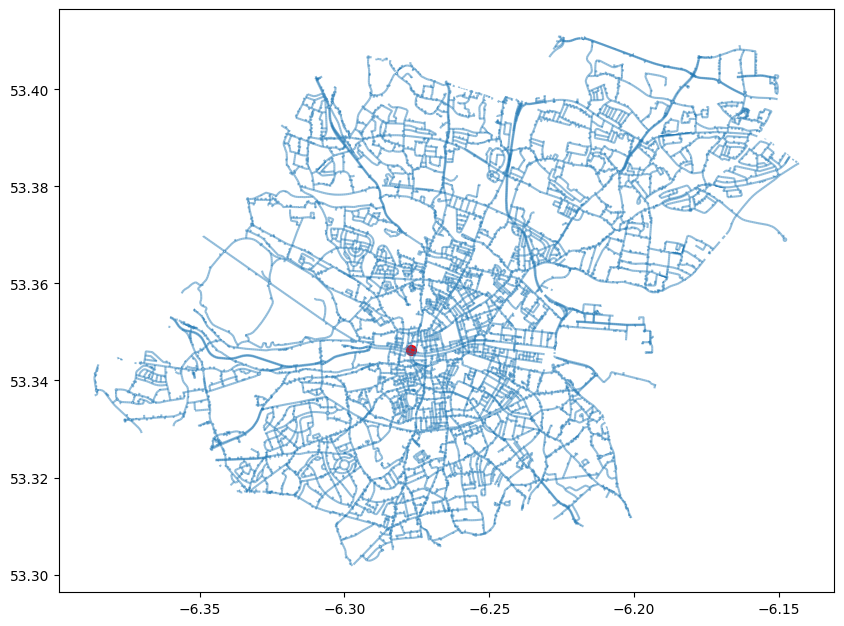

In [4]:
# create a new point at lat=53.3454, lon=-6.2588
house = gpd.GeoDataFrame(geometry=[Point(-6.277133, 53.3463684)], crs=road_segments.crs)

# plot the road segments and the new point
ax = road_segments.plot(figsize=(10, 10), alpha=0.5)
house.plot(ax=ax, color='red', markersize=50)

[]

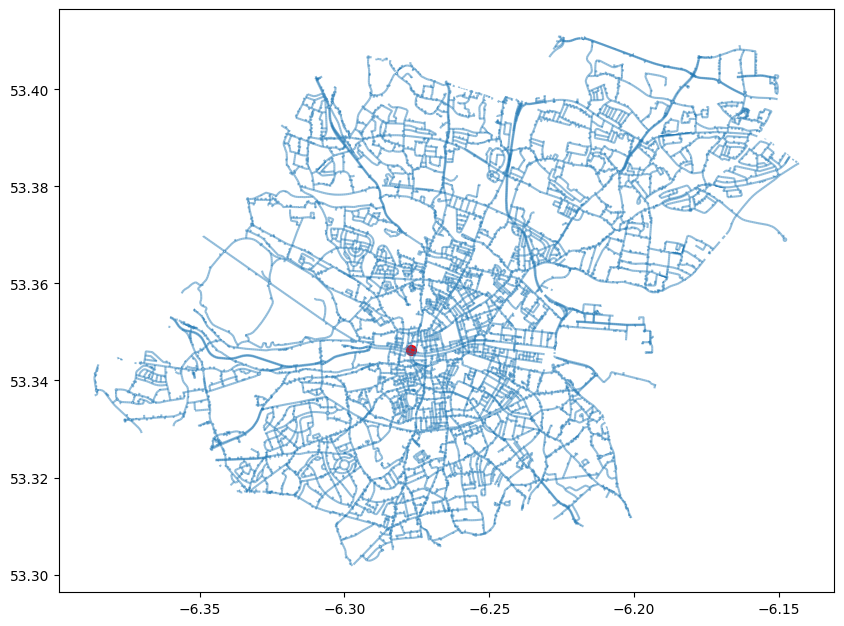

In [5]:
# create a new point at lat=53.3454, lon=-6.2588
Schooner_point = gpd.GeoDataFrame(geometry=[Point(-6.277133, 53.3463684)], crs=road_segments.crs)

# plot the road segments and the new point
ax = road_segments.plot(figsize=(10, 10), alpha=0.5)
Schooner_point.plot(ax=ax, color='red', markersize=50)

# set the x and y limits to zoom in on the point
# ax.set_xlim([-6.280, -6.275])
# ax.set_ylim([53.345, 53.348])

# display the plot
ax.plot()

<Axes: >

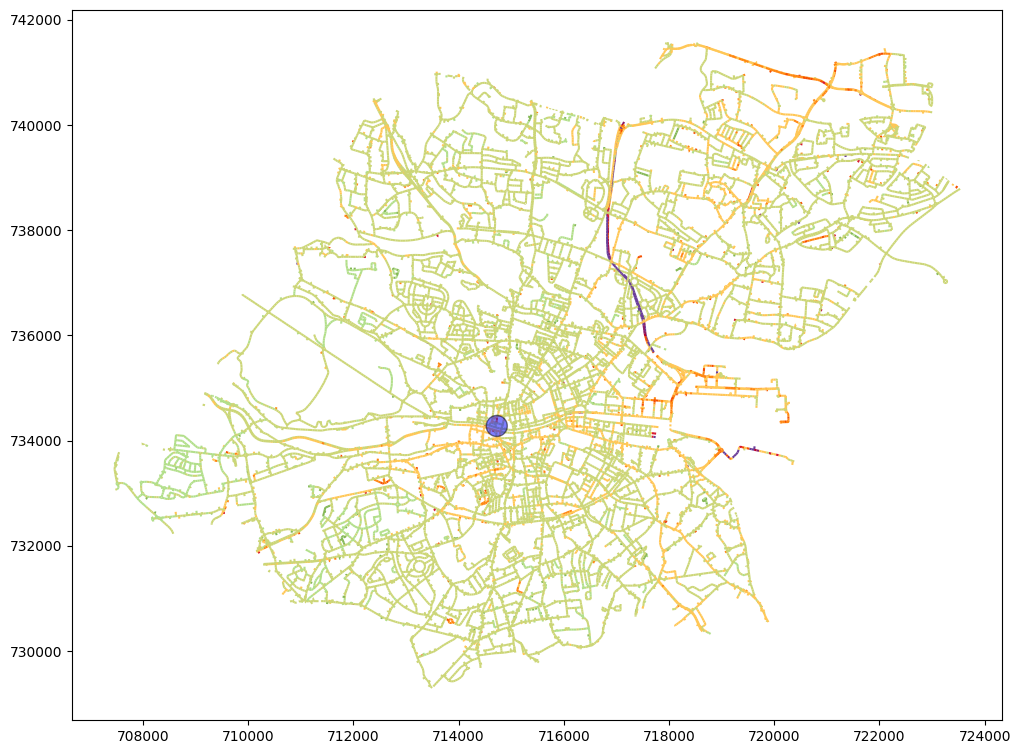

In [6]:
color_dict = {'< 2': '#84B856',
              '2 - 4': '#B2DF8A',
              '4 - 8': '#CCD677',
              '8 - 12': '#FFC756',
              '12 - 16': '#FF8713',
              '16 - 20': '#F54E00',
              '20 - 24': '#D81730',
              '24 - 28': '#B50130',
              '28 - 32': '#8B1D69',
              '> 32': '#6A3D9A'}

bins = [-float('inf'), 2, 4, 8, 12, 16, 20, 24, 28, 32, float('inf')]
labels = ['< 2', '2 - 4', '4 - 8', '8 - 12', '12 - 16', '16 - 20', '20 - 24', '24 - 28', '28 - 32', '> 32']


road_segments['pm2_5_categories'] = pd.cut(road_segments['PM25_ugm3'], bins=bins, labels=labels).map(color_dict)

# ax=road_segments.plot(color=road_segments['pm2_5_categories'], figsize=(12, 12))


# create a new point at lat=53.3454, lon=-6.2588
house = gpd.GeoDataFrame(geometry=[Point(-6.277133, 53.3463684)], crs=road_segments.crs)
# Project the GeoDataFrames to Irish Transverse Mercator
itm_crs = 'EPSG:2157'
house_projected = house.to_crs(itm_crs)
road_segments_projected = road_segments.to_crs(itm_crs)

# Apply the 200-meter buffer on the projected house point for pm2.5 air Quality
buffer_distance = 200  # distance in meters


house_zone=gpd.GeoDataFrame(geometry=house_projected['geometry'].buffer(buffer_distance), crs=itm_crs)
# buffer_bounds = house_buffer.bounds

bounds = house_zone.geometry.bounds
minx = bounds['minx'].iloc[0]
miny = bounds['miny'].iloc[0]
maxx = bounds['maxx'].iloc[0]
maxy = bounds['maxy'].iloc[0]

ax = road_segments_projected.plot(color=road_segments_projected['pm2_5_categories'], figsize=(12, 12))

house_zone.plot(ax=ax, color='blue', alpha=0.5, edgecolor='black', zorder=2)

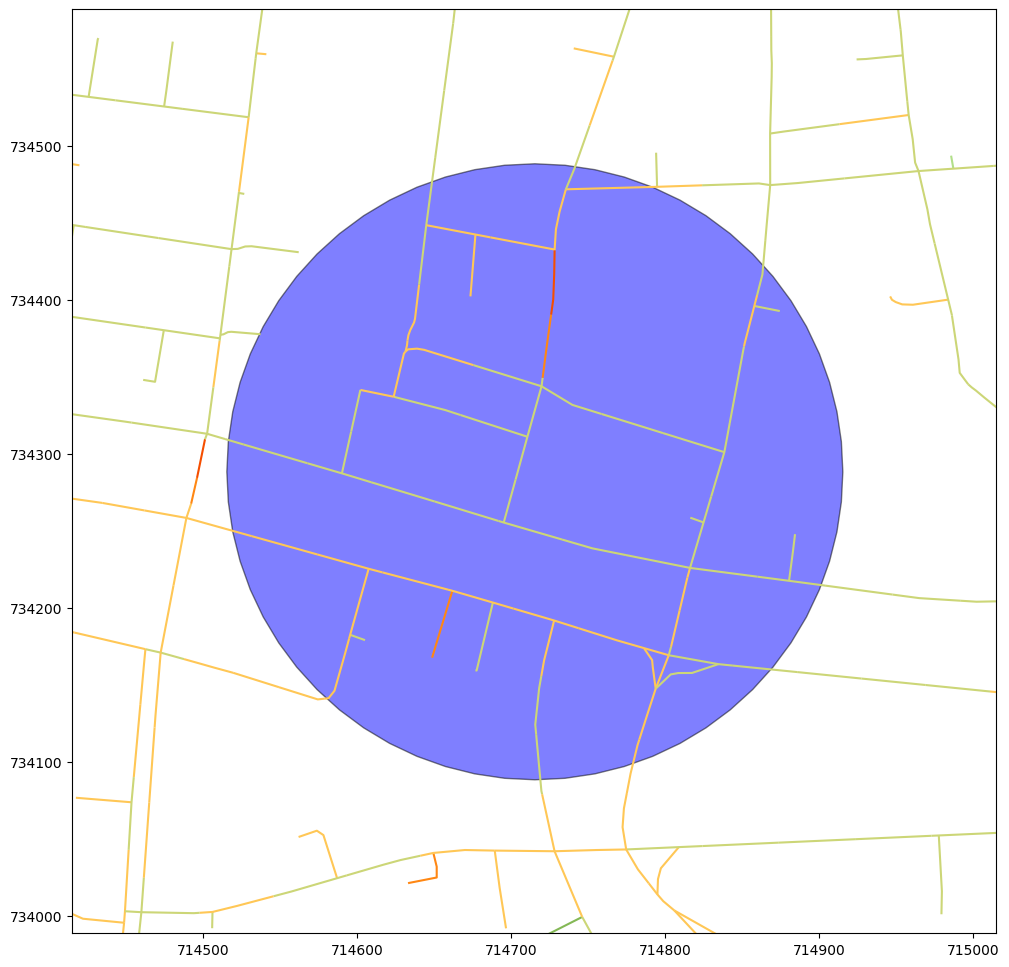

In [7]:
ax = road_segments_projected.plot(color=road_segments_projected['pm2_5_categories'], figsize=(12, 12))

house_zone.plot(ax=ax, color='blue', alpha=0.5, edgecolor='black')

# Set the x and y limits to the buffer area
buffer_padding = 100  # Add extra padding to the plot (in meters)
ax.set_xlim(minx - buffer_padding, maxx + buffer_padding)
ax.set_ylim(miny - buffer_padding, maxy + buffer_padding)

# Show the plot
plt.show()

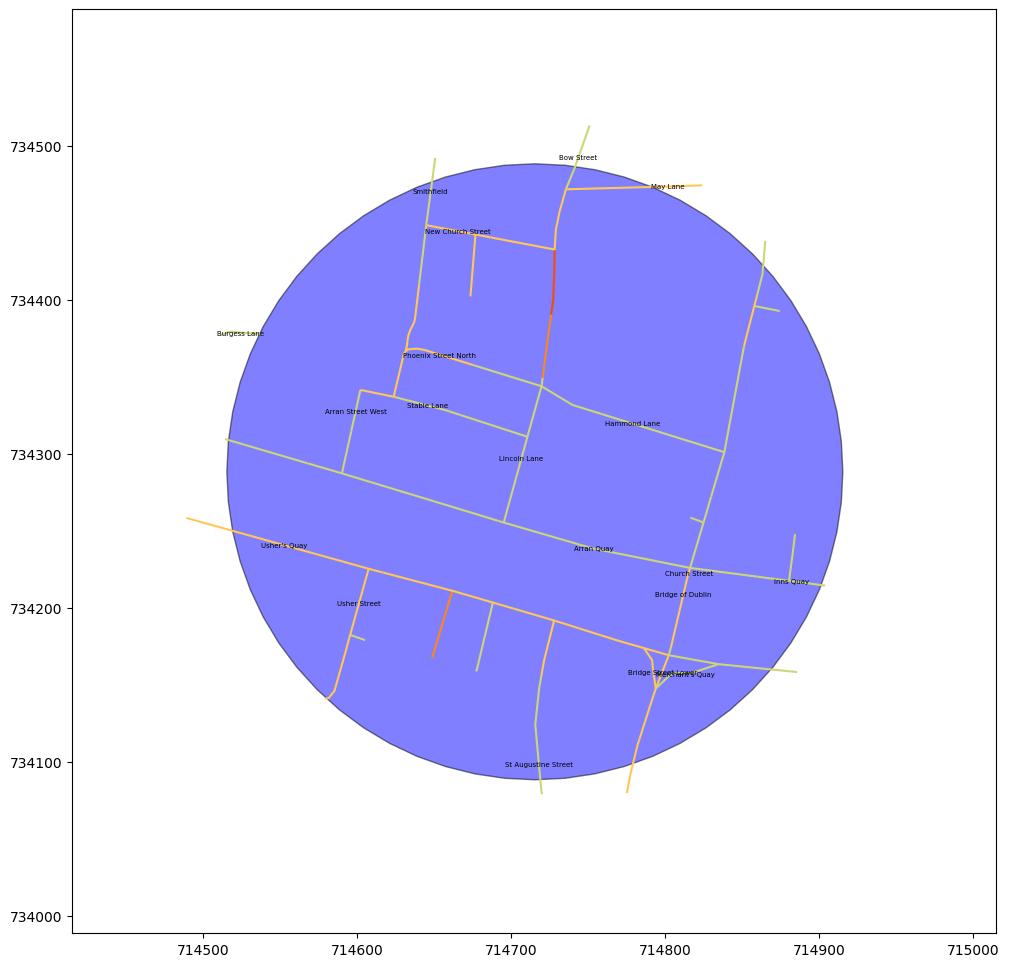

In [8]:
intersecting_roads = gpd.sjoin(road_segments_projected, house_zone, predicate='intersects')
ax=intersecting_roads.plot(color=intersecting_roads['pm2_5_categories'], figsize=(12, 12))

house_zone.plot(ax=ax, color='blue', alpha=0.5, edgecolor='black')

# Set the x and y limits to the buffer area
buffer_padding = 100  # Add extra padding to the plot (in meters)
ax.set_xlim(minx - buffer_padding, maxx + buffer_padding)
ax.set_ylim(miny - buffer_padding, maxy + buffer_padding)

road_names=set()
for idx, row in intersecting_roads.iterrows():
    if not pd.isna(row['osm_name']) and row['osm_name'] not in road_names:
        ax.annotate(row['osm_name'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                    fontsize=5, color='black', ha='center', va='center')
        road_names.add(row['osm_name'])

# Show the plot
plt.show()

In [9]:
intersecting_roads

,road_id,osm_id,osm_code,osm_fclass,osm_name,osm_ref,osm_oneway,osm_maxspe,osm_layer,osm_bridge,...,CO_mgm3,O3points,O3drives,O3_ugm3,PM25points,PM25drives,PM25_ugm3,geometry,pm2_5_categories,index_right
386,550380,57936323,5141,service,NaN,NaN,B,0,0,false,...,0.424,1,1.0,20.258,1,1.0,5.491,"LINESTRING (714688.174 734203.390, 714677.614 ...",#CCD677,0
519,1983055,227983488,5141,service,NaN,NaN,B,0,0,false,...,0.428,1,1.0,56.666,1,1.0,11.948,"LINESTRING (714676.859 734442.362, 714673.606 ...",#FFC756,0
668,550382,57936323,5141,service,NaN,NaN,B,0,0,false,...,0.407,0,NaN,NaN,1,1.0,14.326,"LINESTRING (714648.713 734167.598, 714661.869 ...",#FF8713,0
6140,3538384,442035824,5141,service,NaN,NaN,B,0,0,false,...,0.412,4,4.0,37.131,8,8.0,7.539,"LINESTRING (714605.150 734178.968, 714595.500 ...",#CCD677,0
7765,20777,4908185,5114,secondary,Church Street,R108,B,50,0,false,...,0.504,6,6.0,43.680,15,13.0,10.367,"LINESTRING (714814.445 734219.519, 714816.210 ...",#FFC756,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24423,3694461,529166754,5114,secondary,Usher's Quay,R148,F,50,0,false,...,0.540,52,43.0,36.020,166,87.0,8.400,"LINESTRING (714802.384 734169.177, 714786.257 ...",#FFC756,0
24455,13971,4401781,5114,secondary,Usher's Quay,R148,F,50,0,false,...,0.547,193,76.0,36.242,679,90.0,8.827,"LINESTRING (714786.257 734173.808, 714768.828 ...",#FFC756,0
24456,13972,4401781,5114,secondary,Usher's Quay,R148,F,50,0,false,...,0.534,193,78.0,35.410,599,90.0,9.119,"LINESTRING (714743.887 734186.698, 714727.933 ...",#FFC756,0
24496,5272,3789575,5114,secondary,Merchant's Quay,R148,F,50,0,false,...,0.484,1007,80.0,35.561,3668,97.0,7.663,"LINESTRING (714885.764 734158.237, 714844.030 ...",#CCD677,0


In [38]:
# Create a map with the Google TERRAIN basemap
m = leafmap.Map(google_map="TERRAIN")

# Set the map center and zoom level
m.set_center(lon=-6.277133, lat=53.3463684, zoom=16)

# Convert intersecting_roads and house_zone GeoDataFrames to EPSG:4326 CRS
intersecting_roads_4326 = intersecting_roads.to_crs(epsg=4326)
house_zone_4326 = house_zone.to_crs(epsg=4326)

# Convert the house_zone GeoDataFrame to GeoJSON
house_zone_geojson = json.loads(house_zone_4326.to_json())

# Create a GeoJSON layer from the house_zone GeoJSON and add it to the map
house_zone_layer = GeoJSON(data=house_zone_geojson, name="House Zone", style={'color': 'blue', 'opacity': 0.5, 'fillOpacity': 0.5})
m.add_layer(house_zone_layer)

# Convert the intersecting_roads GeoDataFrame to GeoJSON
intersecting_roads_geojson = json.loads(intersecting_roads_4326.to_json())

# Loop through the features and set the color property
for feature, color in zip(intersecting_roads_geojson['features'], intersecting_roads['pm2_5_categories']):
    feature['properties']['style'] = {'color': color, 'weight': 5}

# Create a GeoJSON layer from the intersecting_roads GeoJSON and add it to the map
intersecting_roads_layer = GeoJSON(data=intersecting_roads_geojson, name="Intersecting Roads")
m.add_layer(intersecting_roads_layer)

# Add the control for layer selection
m.add_layer_control()

legend_items = {f"PM2.5 {key} µg/m³": value for key, value in color_dict.items()}

# Add the legend to the map
m.add_legend(legend_title="PM2.5 Concentrations", legend_dict=legend_items)

# Display the map
m

Map(center=[53.3463684, -6.277133], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

In [42]:
# Simple non weighted mean
intersecting_roads_4326['PM25_ugm3'].mean()

8.073808219178083